# Simple ARIMA model for non-seasonal time-serie forecast

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data and Plot Time Series
Let's start by loading the time series of the challenge and plot the time series

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

<AxesSubplot:>

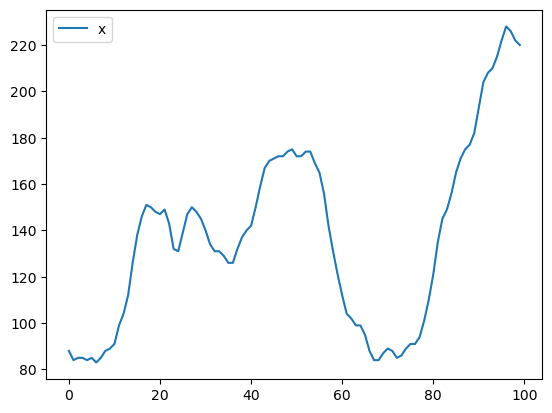

In [3]:
df = pd.read_csv('data/daily_restaurant_sales.csv')
df.plot()

This abstract time serie does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regresive Moving Average (ARIMA) models


## 2. Build ARIMA model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time serie (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the Moving-Average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure stationarity

ARIMA models applies to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [5]:
y=df

In [6]:
from statsmodels.tsa.stattools import adfuller
adfuller(y, autolag='AIC')

(-2.464239717203369,
 0.12441935447109442,
 3,
 96,
 {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 444.67104090432554)

The p-value should be  less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat process on the differentiated serie if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationnary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

In [7]:
y_diff1 = y.diff().dropna()
#.dropna() su
y_diff2 = y_diff1.diff().dropna()

In [8]:
adfuller(y_diff1, autolag='AIC')

(-2.722238490442951,
 0.07026846015272728,
 2,
 96,
 {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 438.89606128026)

In [9]:
adfuller(y_diff2, autolag='AIC')

(-9.929762173626015,
 2.843428755547158e-17,
 1,
 96,
 {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 438.2804466027877)

We have a close-call here between one and two diff orders. Differentiating too much a time series may also reduce performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

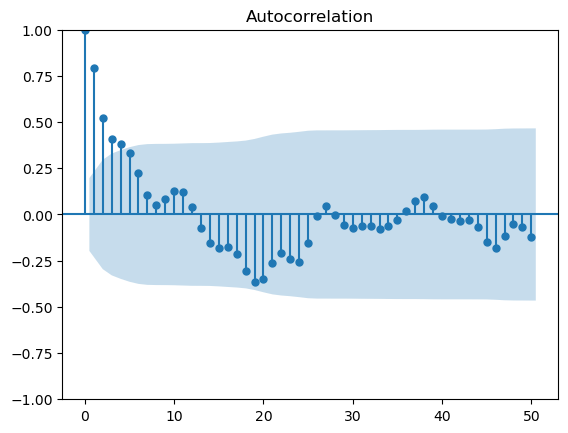

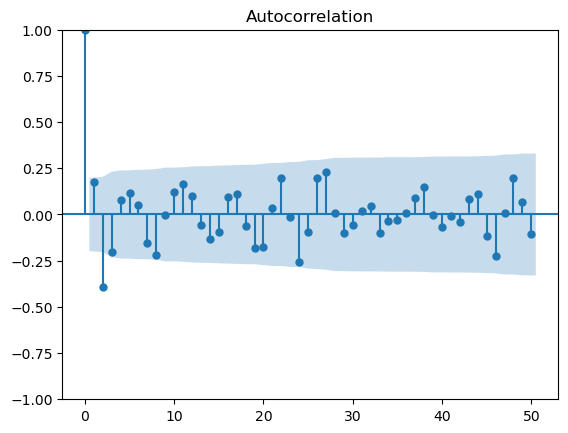

In [14]:
plot_acf(y_diff1,lags = 50)
plot_acf(y_diff2,lags = 50)
plt.show()

In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (temptatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

In [15]:
y_diff = y.diff().dropna()

We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary (I refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

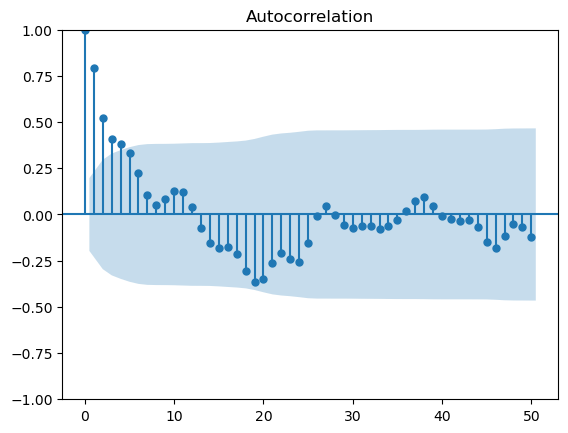

In [16]:
plot_acf(y_diff1,lags = 50);


We could choose q = 4, but it's more conservatively to try with `q=2` to start with.

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

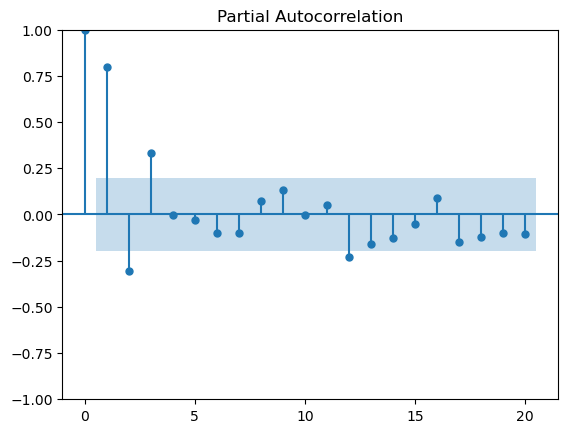

In [17]:
plot_pacf(y_diff1);

We could choose `p = 3` as the first 3 lag terms seems above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d` and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the the model
- print the model (`.summary`)

In [25]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y, order=(1, 1, 2))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      x   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Wed, 08 Mar 2023   AIC                            516.253
Time:                        12:32:10   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.671      -0.373       0.241
sigma2         9.7898      1.421      6.889      0.000       7.005      12.575
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.98   Prob(JB):                         0.95
Heteroskedasticity (H):               0.63   Skew:                            -0.07
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

☝️ If your p-values are too high, try remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate overall performance of your fit by minimizing the [`AIC - akaike information criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remains low) and maintain a quasi similar AIC score than other models

In [26]:
model = ARIMA(y, order=(1, 1, 1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      x   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -254.150
Date:                Wed, 08 Mar 2023   AIC                            514.300
Time:                        12:32:12   BIC                            522.086
Sample:                             0   HQIC                           517.450
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6504      0.090      7.258      0.000       0.475       0.826
ma.L1          0.5256      0.088      5.994      0.000       0.354       0.697
sigma2         9.7934      1.405      6.970      0.000       7.040      12.547
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.86   Prob(JB):                         0.94
Heteroskedasticity (H):               0.63   Skew:                            -0.08
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 3. Evaluate model performance

👉 Visualize your model predictions with `.plot_predict()`

- Look closely at the method default params, especially `dynamic`. 
- Do you think your model would have such good performance in reality?

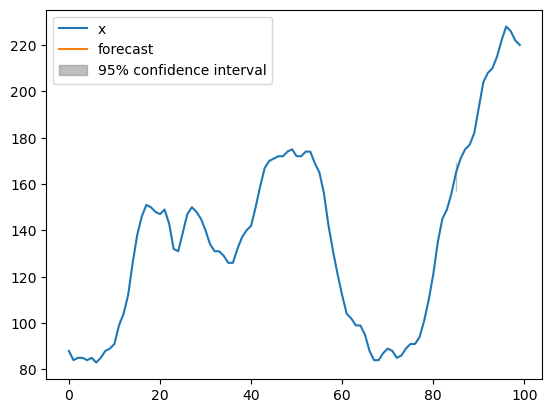

In [31]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots()
ax = df.x.plot(ax=ax)
plot_predict(model,df.index[85], ax=ax, dynamic=True)
plt.show()

☝️ `dynamic=False` actually makes use of all available values `y` in order to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prection of the _last 15 values_ in a situation where the model only have _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ it's previouly predicted value for 86
- etc...iteratively until 100

☝️ That's still not a _true_ forecast!! Why??

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` serie during the fitting phase!
</details>

### 3.1 Out-of-sample forecasts (real "future")

👉 Create a train-test-split keep the last 15 datapoints only for the test set, and train your ARIMA on the train set only.

In [28]:
train = y[0:85]
test = y[85:100]
model = ARIMA(train, order=(1, 1, 1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      x   No. Observations:                   85
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -217.055
Date:                Wed, 08 Mar 2023   AIC                            440.109
Time:                        12:36:55   BIC                            447.402
Sample:                             0   HQIC                           443.041
                                 - 85                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6597      0.097      6.790      0.000       0.469       0.850
ma.L1          0.4857      0.099      4.892      0.000       0.291       0.680
sigma2        10.1098      1.595      6.340      0.000       6.984      13.235
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.85   Prob(JB):                         0.99
Heteroskedasticity (H):               0.64   Skew:                             0.03
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

👉 We are "now" in step 85 and have never seen the future:
- Use `.forecast()` method on your fitted model to "forecast" the 15 next datapoints (i.e beyond the end of your train dataset) 
- Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

In [34]:
model.forecast(15)

85    163.161121
86    167.885191
87    171.001581
88    173.057410
89    174.413606
90    175.308266
91    175.898458
92    176.287798
93    176.544638
94    176.714072
95    176.825844
96    176.899579
97    176.948220
98    176.980308
99    177.001476
Name: predicted_mean, dtype: float64

x         mean    mean_se  mean_ci_lower  mean_ci_upper
85  163.161121   3.179587     156.929245     169.392997
86  167.885191   7.526027     153.134450     182.635933
87  171.001581  11.904618     147.668959     194.334203
88  173.057410  16.079401     141.542363     204.572458
89  174.413606  19.976693     135.260009     213.567204
90  175.308266  23.588483     129.075688     221.540844
91  175.898458  26.932996     123.110756     228.686160
92  176.287798  30.037462     117.415454     235.160141
93  176.544638  32.930495     112.002053     241.087223
94  176.714072  35.638867     106.863175     246.564968
95  176.825844  38.186334     101.982005     251.669683
96  176.899579  40.593418      97.337941     256.461216
97  176.948220  42.877607      92.909654     260.986786
98  176.980308  45.053708      88.676663     265.283953
99  177.001476  47.134231      84.620081     269.382870


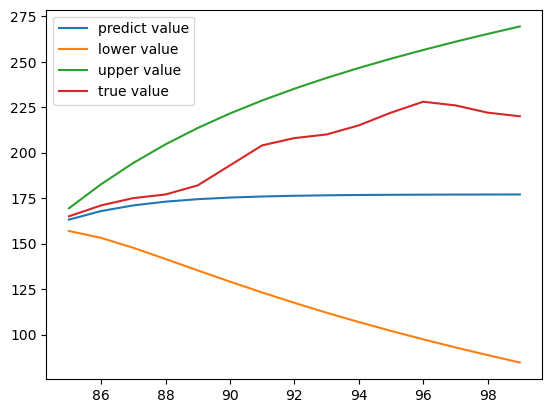

In [46]:
res = model.get_forecast(15)
intervalle = pd.DataFrame(res.summary_frame(alpha=0.05))
print(intervalle)

plt.plot(res.predicted_mean, label='predict value')
plt.plot(intervalle['mean_ci_lower'], label='lower value')
plt.plot(intervalle['mean_ci_upper'], label='upper value')

plt.plot(test, label='true value')
plt.legend()
plt.show()

👉 Try to also plot your previous 85 `y` real datapoints to better grasp model performance relative to the past

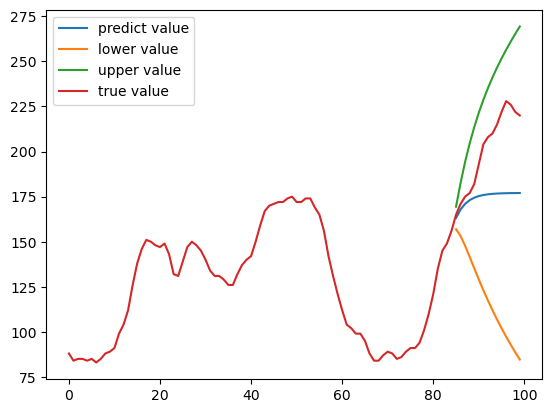

In [59]:
plt.plot(res.predicted_mean, label='predict value')
plt.plot(intervalle['mean_ci_lower'], label='lower value')
plt.plot(intervalle['mean_ci_upper'], label='upper value')

plt.plot(df, label='true value')
plt.legend()
plt.show()

### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals if you really want)

Note: residuals are constructed by 'seing' all data as in `plot_predict(dynamic=False)`

Also try to plot a histogram or kde fit of the residuals to see if they are approximately normally distributed.

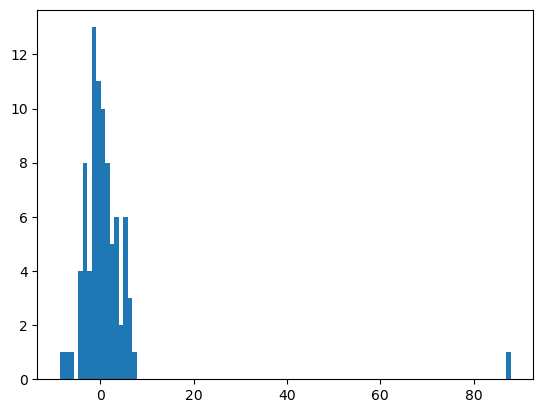

1.2664827730604251

In [55]:
plt.hist(model.resid, 100)
plt.show()
model.resid.mean()

## 3.3 Cross-validated performance metrics

👉 Below are the given the most common performance metrics for time series

In [60]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

👉 Play with you ARIMA hyper-parameters and see the impact on your forecast performance

In [68]:
model = ARIMA(train, order=[1, 1, 1]).fit()
y_pred = model.forecast(15)
y_true = test["x"]
print(forecast_accuracy(y_pred,y_true))

model = ARIMA(train, order=[1, 2, 1]).fit()
y_pred = model.forecast(15)
y_true = test["x"]
print(forecast_accuracy(y_pred,y_true))

model = ARIMA(train, order=[4, 2, 1]).fit()
y_pred = model.forecast(15)
y_true = test["x"]
print(forecast_accuracy(y_pred,y_true))

{'mape': 0.12522186405285302, 'me': -26.871495452829937, 'mae': 26.871495452829937, 'mpe': -0.12522186405285302, 'rmse': 32.38238199159855, 'acf1': 0.8714402848280138, 'corr': 0.8528510991437283, 'minmax': 0.12522186405285296}
{'mape': 0.09407429546910154, 'me': 19.950522190865435, 'mae': 20.025621743983034, 'mpe': 0.09361914666232819, 'rmse': 25.536648863994873, 'acf1': 0.6892321327701716, 'corr': 0.9562945743922217, 'minmax': 0.0824686390105428}
{'mape': 0.05501159244464044, 'me': -11.084765937873145, 'mae': 11.87434138698605, 'mpe': -0.05058214126666325, 'rmse': 14.819786525444659, 'acf1': 0.8749521755933549, 'corr': 0.9714750551387695, 'minmax': 0.054983252500862445}


## 4 Grid Search
#link to understand Grid Search https://www.lovelyanalytics.com/2017/10/16/grid-search/

Try to run your own gridsearch for (p,d,q) using `pmdarima`. Use at least
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [69]:
!pip install pmdarima
import pmdarima as pm

In [74]:
model_fit = pm.auto_arima(train, start_p=1, start_q=1,
                          max_p=4, max_q=4,
                          start_P=0,
                          d=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True, 
                          seasonal=False
                             )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=441.776, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=534.403, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=451.228, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=469.552, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=534.088, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=443.729, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=443.636, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=446.963, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=446.570, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=445.229, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=440.109, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=468.807, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=449.462, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=442.052, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=441.9

## Cross-validate performance of your model

In practice, Results and GridSearch should always be cross validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create continguous K-folds so as to truely evaluate the performance of your model and find the best hyper-params after cross validation

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>

In [75]:
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import TimeSeriesSplit
from pmdarima.arima import auto_arima

# Define the search parameters
search_params = {
    'seasonal': False,
    'stepwise': True,
    'suppress_warnings': True,
    'scoring': 'mse',
    'max_order': None,
    'order': None,
    'out_of_sample_size': 0,
    'n_jobs': -1,
    'start_p': 1,
    'start_q': 1,
    'd': None,
    'D': None,
    'seasonal_order': None,
    'start_P': 1,
    'start_Q': 1,
    'max_P': 5,
    'max_Q': 5,
    'test': 'adf',
    'stepwise': True,
}

# Define the time series cross-validator
cv = TimeSeriesSplit(n_splits=3)

# Perform grid search with cross-validation to find best ARIMA parameters
model = auto_arima(train, 
                   seasonal=False, 
                   start_p=1, 
                   start_q=1, 
                   max_p=5, 
                   max_q=5, 
                   suppress_warnings=True, 
                   stepwise=True, 
                   scoring='mse', 
                   error_action='ignore', 
                   n_jobs=-1, 
                   information_criterion='aic', 
                   out_of_sample_size=0, 
                   cv=cv)

# Print the best parameters found
print("Best (p,d,q) values: ", model.order)

C:\Users\utilisateur\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Best (p,d,q) values:  (2, 0, 3)
